In [ ]:
import pandas as pd
import numpy as np
import pickle
import sys
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing

from keras import Sequential, regularizers 

from keras.layers import Embedding, LSTM, Dense
from keras import losses
from keras.layers import Dense
from keras.layers import Flatten, InputLayer

import time
from keras.callbacks import EarlyStopping, ModelCheckpoint
import torch
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn import metrics
import plotly.express as px

from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
# from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import backend as K
from keras import optimizers
from keras.models import Model
from nltk import tokenize
import nltk
nltk.download('punkt')

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
path_df = "/content/drive/MyDrive/fake_bert/politifact_global_feature.pkl"

In [ ]:
df = pickle.load(open(path_df, "rb"))

In [ ]:
df.head()

,text,title,top_img,publish_date,images,source,target,tweet_mod,comp_text,lem_text,...,Sen15,Sen16,Sen17,Sen18,Sen19,G1,G2,G3,G4,G5
id,,,,,,,,,,,,,,,,,,,,,
politifact720,Organizing for ’18\n\nThrough Election Day\n\n...,Organizing for Action,https://secure.assets.bostatic.com/apps/quincy...,None,[https://secure.assets.bostatic.com/apps/quinc...,politifact,1,"[{'time': None, 'type': 1, 'user': 1716929114,...",Organizing for 18 Through Election Day Sometim...,organize for 18 through election day sometimes...,...,0.949437,0.034845,0.071476,1.681818,0.011628,0.012289,79.0,86.0,1.866903e-04,85.0
politifact10731,"COLUMBUS, Ohio — America's role as a world lea...",Call 'Islamic terrorism' what it is: a threat ...,http://triblive.com/csp/mediapool/sites/dt.com...,1429079762.0,[http://triblive.com/csp/mediapool/sites/TribL...,politifact,1,"[{'time': None, 'type': 1, 'user': 1716929114,...",COLUMBUS Ohio America's role as a world leader...,columbus ohio americas role a a world leader a...,...,0.694333,0.000000,-0.738400,1.250000,0.041667,0.046498,20.0,24.0,3.071834e-03,23.0
politifact11115,"In the course of the email review, State Depar...",Inquiry Sought in Hillary Clinton’s Use of Email,https://static01.nyt.com/images/2015/07/24/us/...,1437721200.0,[https://static01.nyt.com/images/2015/07/24/us...,politifact,1,"[{'time': None, 'type': 1, 'user': 1716929114,...",In the course of the email review State Depart...,in the course of the email review state depart...,...,0.778346,0.012754,-0.472698,1.156863,0.000543,0.000609,1673.0,1842.0,5.721557e-07,1841.0
politifact14148,We all get lazy from time to time and just wan...,NASA Will Pay You 18000 USD To Stay In Bed And...,http://reflectionofmind.org/wp-content/uploads...,1482942009.0,[http://reflectionofmind.org/wp-content/upload...,politifact,0,"[{'time': None, 'type': 1, 'user': 1716929114,...",We all get lazy from time to time and just wan...,we all get lazy from time to time and just wan...,...,0.829039,0.098993,0.134468,1.240000,0.000836,0.000885,1089.0,1196.0,1.024639e-06,1195.0
politifact6932,"Mitt Romney came to coal country on Aug. 14, s...",Barack Obama says Mitt Romney condemned coal-f...,http://static.politifact.com.s3.amazonaws.com/...,1345705200.0,[http://metric.politifact.com/b/ss/spttbglobal...,politifact,1,"[{'time': None, 'type': 1, 'user': 1716929114,...",Mitt Romney came to coal country on Aug. 14 st...,mitt romney come to coal country on aug 14 sta...,...,0.642184,0.016658,-0.765808,1.000000,0.025000,0.025214,38.0,40.0,6.738988e-04,39.0


In [ ]:
sent_lens = []
sent_nums = []
texts = []
paras = []

for idx in range(df["comp_text"].shape[0]):
    text = df["comp_text"][idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(text_to_word_sequence(sent)))
    print(len(sentences))
    paras.append(sentences)

In [ ]:
# sentences[0]
# print("---")
paras[0]
# len(paras[2])

['Organizing for 18 Through Election Day Sometimes fighting for progress on the issues means fighting to win on election day.',
 "This year many of the issues we've fought for for years are on the ballot so we're Organizing for 18.",
 'Host or find an event near you this election season.',
 'Find an event']

In [ ]:
max_features=10000
max_senten_len=40
max_senten_num=6
embed_size=100
VALIDATION_SPLIT = 0.2

In [ ]:
tokenizer = Tokenizer(num_words=max_features, oov_token=True)
tokenizer.fit_on_texts(texts)
data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_senten_len and tokenizer.word_index[word]<max_features:
                        data[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


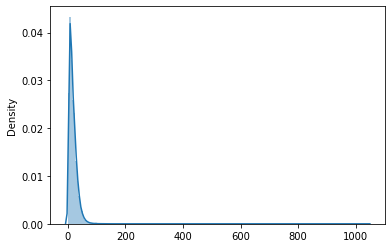

In [ ]:
sns.distplot(sent_lens, bins=200)
plt.show()

In [ ]:
sent_lens

In [ ]:
data.shape

(312, 6, 40)

In [ ]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 17560 unique tokens.


In [ ]:
labels = pd.get_dummies(df["target"])
# labels = df["target"]

In [ ]:
fea_st_col = df.iloc[:, 10:10 + 14 + 13].columns
fea_sen_col = df.iloc[:, 10 + 14 + 13 + 6:10 + 14 + 13 + 6 + 19].columns

In [ ]:
union_cols = fea_st_col.union(fea_sen_col)

In [ ]:
sample_feature_array = df[union_cols]

In [ ]:
print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', labels.shape)
print('Shape of sample_feature_array tensor:', sample_feature_array.shape)

Shape of data tensor: (312, 6, 40)
Shape of labels tensor: (312, 2)
Shape of sample_feature_array tensor: (312, 46)


In [ ]:
indices = np.arange(data.shape[0])

In [ ]:
data = data[indices]

In [ ]:
data.shape

(312, 6, 40)

In [ ]:
x_train, x_test, y_train, y_test, f_train, f_test = train_test_split(data, df['target'], sample_feature_array, test_size= .15, random_state= 111, stratify= df['target'] )
x_train, x_val, y_train, y_val, f_train, f_val= train_test_split(x_train, y_train,f_train, test_size= .10, random_state= 111, stratify= None )

In [ ]:
x_train

In [ ]:
x_train.shape

(238, 6, 40)

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(data, df['target'], test_size= .15, random_state= 111, stratify= None )
# x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size= .10, random_state= 111, stratify= None )

indices = np.arange(data.shape[0])
# np.random.shuffle(indices)
data = data[indices]
labels = labels.iloc[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
print('Number of positive and negative reviews in traing and validation set')
f_train = sample_feature_array[:-nb_validation_samples]
f_val = sample_feature_array[-nb_validation_samples:]
# print(y_train.columns.tolist())
# print(y_train.sum(axis=0).tolist())
# print(y_val.sum(axis=0).tolist())

Number of positive and negative reviews in traing and validation set


In [ ]:
x_train[0]

In [ ]:
f_train = sample_feature_array[:-nb_validation_samples]
f_val = sample_feature_array[-nb_validation_samples:]

In [ ]:
f_val.shape

(62, 57)

In [ ]:
y_val

,0,1
id,,
politifact15371,1,0
politifact13132,0,1
politifact15187,1,0
politifact14289,1,0
politifact8152,0,1
...,...,...
politifact7511,0,1
politifact160,0,1
politifact13443,0,1


In [ ]:
x_train.shape

(238, 6, 40)

In [ ]:
y_train.shape

(238,)

In [ ]:
labels

,0,1
id,,
politifact720,0,1
politifact10731,0,1
politifact11115,0,1
politifact14148,1,0
politifact6932,0,1
...,...,...
politifact7511,0,1
politifact160,0,1
politifact13443,0,1


In [ ]:
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip


In [ ]:
# !unzip glove*.zip


In [ ]:
GLOVE_DIR = "/content/drive/MyDrive/glove.6B.100d.txt"
embeddings_index = {}
f = open(GLOVE_DIR)
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = values[1:]
        # coefs = np.asarray(y, dtype='float32')
        embeddings_index[word] = coefs
    except:
        print("except")
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [ ]:
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 978 which is 5.57 % of total words


In [ ]:
embedding_layer = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_senten_len, trainable=False)

In [ ]:
# from keras.engine.topology import Layer
from tensorflow.keras.layers import Layer, InputSpec

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(tf.keras.layers.Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, context_vector_length = 1000, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.context_vector_length = context_vector_length
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        print('{}_W'.format(self.name))
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

    def get_config(self):
        config = {
            'context_vector_length': self.context_vector_length
        }
        base_config = super(AttentionWithContext, self).get_config()
        return {**base_config, **config}


In [ ]:
word_input = Input(shape=(max_senten_len,), dtype='float32')
word_sequences = embedding_layer(word_input)
embeding_dim = 128
word_lstm = Bidirectional(LSTM(embeding_dim, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)

sent_input = Input(shape=(max_senten_num, max_senten_len), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(embeding_dim, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.2)(AttentionWithContext()(sent_dense))
# sentEncoder = Model(sent_input, sent_att)
# preds = Dense(2, activation='sigmoid')(sent_att)
dense_cat = Dense(128, activation='relu')(sent_att)
# dense_cat shape == feature.shape 1 dim will be diff and rest same. 
feature_input = Input(shape=f_train.shape[1], dtype='float64', name='text')
# fea_encoder = TimeDistributed(sent_encoder)(text_input)

# embedded_text = tf.keras.layers.Embedding(64, len(f_train))(text_input)
# encoded_feature = tf.keras.layers.LSTM(64)(feature_input)
#shape of feature vector
# feature_input = Input(shape=(sample_feature_array.shape), dtype='float64')
# feature_encoder = tf.keras.layers.TimeDistributed(sample_feature_array)(feature_input)

# feature_encoder = TimeDistributed(sample_feature_array)(feature_input)
# feature_lstm = Bidirectional(LSTM(embeding_dim, return_sequences=True, kernel_regularizer=l2_reg))(feature_encoder)
# feature_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(feature_lstm)
# feature_att = Dropout(0.5)(AttentionWithContext()(feature_dense))
# merged = tf.keras.layers.concatenate([encoded_feature, dense_cat],axis=-1)
merged = tf.keras.layers.Concatenate(axis=1)([feature_input, dense_cat])

preds = tf.keras.layers.Dense(2, activation='softmax')(merged)
# merged = tf.keras.layers.concatenate([dense_cat, feature_input])

# preds = Dense(2, activation='sigmoid')(concatenated)

model = Model([sent_input, feature_input], preds)
# model = Model(preds, sent_input, text_input)
# model.add(GlobalAveragePooling2D())


attention_with_context_W
attention_with_context_1_W


In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(1e-3),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 40)]      0           []                               
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 6, 200)      2082396     ['input_2[0][0]']                
 buted)                                                                                           
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 6, 256)      336896      ['time_distributed_1[0][0]']     
 )                                                                                                
                                                                                            

In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
scaler = preprocessing.MinMaxScaler()
f_train_transform = scaler.fit_transform(f_train)
f_val_transform = scaler.fit_transform(f_val)
f_test_transform = scaler.fit_transform(f_test)

In [ ]:
merged_train_arr = [x_train, f_train_transform]
merged_val_arr = [x_val, f_val_transform]
# merged_test_arr = [x_test, f_test_transform]

In [ ]:
merged_val_arr

In [ ]:
start = time.time()
berthist = model.fit(merged_train_arr, y_train, validation_data= (merged_val_arr, y_val), epochs=100, batch_size=64, verbose=1, callbacks=[earlyStopping, mcp_save])
print(time.time()-start)

Epoch 1/100
4/4 [==============================] - 18s 2s/step - loss: 0.7237 - accuracy: 0.4040 - val_loss: 0.6658 - val_accuracy: 0.5645
Epoch 2/100
4/4 [==============================] - 3s 837ms/step - loss: 0.6928 - accuracy: 0.5080 - val_loss: 0.6414 - val_accuracy: 0.6935
Epoch 3/100
4/4 [==============================] - 3s 838ms/step - loss: 0.6306 - accuracy: 0.6280 - val_loss: 0.5466 - val_accuracy: 0.7258
Epoch 4/100
4/4 [==============================] - 3s 818ms/step - loss: 0.5250 - accuracy: 0.7480 - val_loss: 0.5567 - val_accuracy: 0.7258
Epoch 5/100
4/4 [==============================] - 3s 801ms/step - loss: 0.4884 - accuracy: 0.7760 - val_loss: 0.5997 - val_accuracy: 0.7258
Epoch 6/100
4/4 [==============================] - 3s 833ms/step - loss: 0.5133 - accuracy: 0.7400 - val_loss: 0.4421 - val_accuracy: 0.8387
Epoch 7/100
4/4 [==============================] - 3s 803ms/step - loss: 0.4811 - accuracy: 0.7760 - val_loss: 0.4476 - val_accuracy: 0.8387
Epoch 8/100
4/4

In [ ]:
file_name = "/content/drive/MyDrive/fake_bert/HAN_model_finetune"

In [ ]:
torch.save(model, file_name)

In [ ]:
# hanModel_pred = model.predict([x_val, f_val])
# hanLayerModel_y = np.argmax(hanModel_pred, axis = 1)
# hanLayerModel_y

hanModel_pred = model.predict(merged_val_arr)
hanLayerModel_y = np.argmax(hanModel_pred, axis = 1)
hanLayerModel_y

2/2 [==============================] - 3s 146ms/step


array([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1])

In [ ]:
len(hanLayerModel_y)

62

In [ ]:
len(y_val[1].values)

62

In [ ]:
print('Accuracy:', accuracy_score(hanLayerModel_y, y_val[1].values))
print('F1 score:', f1_score(y_val[1].values, hanLayerModel_y))
print('Recall:', recall_score(np.array(y_val[1]), hanLayerModel_y))
print('Precision:', precision_score(np.array(y_val[1]), hanLayerModel_y))
print('ROC_AUC Score:', roc_auc_score(np.array(y_val[1]), hanLayerModel_y))

print(classification_report(np.array(y_val[1]), hanLayerModel_y))

Accuracy: 0.7741935483870968
F1 score: 0.7407407407407406
Recall: 0.625
Precision: 0.9090909090909091
ROC_AUC Score: 0.7791666666666667
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        30
           1       0.91      0.62      0.74        32

    accuracy                           0.77        62
   macro avg       0.80      0.78      0.77        62
weighted avg       0.81      0.77      0.77        62



In [ ]:
hanLayerModel_y